In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
import sys
from sksurv.metrics import concordance_index_ipcw,concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler
from pickle import load
from sksurv.nonparametric import kaplan_meier_estimator,SurvivalFunctionEstimator
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer
)
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import TSNE
from pickle import dump
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

from sksurv.svm import FastKernelSurvivalSVM

In [2]:
n_folds = 5
random_state = 108
from datetime import date

today = date.today()
today_stf = '20241008'

In [3]:
try:
    results = pd.read_csv("results/outcome.csv",index_col=0)
except:
    results = pd.DataFrame(columns = ["model",
                                      "test_ci","test_ipcw","test_auc","test_brier","n_features"])

In [5]:
from sksurv.metrics import cumulative_dynamic_auc
def calc_dyn_auc(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    chf_funcs = model.predict_cumulative_hazard_function(X)
    risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y, risk_scores, times)

    return auc, mean_auc,times

In [6]:
from sksurv.metrics import integrated_brier_score
def calc_ibs(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    surv_prob = np.vstack([fn(times) for fn in model.predict_survival_function(X)])
    ibs = integrated_brier_score(y_train, y, surv_prob, times)

    return ibs

In [7]:
def plot_auc(cph_auc,cph_mean_auc,times):
    plt.plot(times, cph_auc, "o-", label=f"Mean AUC = {cph_mean_auc:0.3f})")
    plt.axhline(cph_mean_auc, linestyle="--",color='r')
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

In [8]:
def plot_cph_coef(cph,feature_names=None):
    coefs = cph.coef_.reshape((-1))
    if feature_names is None:
        feature_names = cph.feature_names_in_
    df = pd.Series(index = feature_names,data=coefs)
    non_zero_coef = df[abs(df) > 0.01].sort_values(ascending=False, key=abs).head(20)
    ax = sns.barplot(x=non_zero_coef.index, y=non_zero_coef.values)
    plt.setp(ax.get_xticklabels(), rotation=45)
    return df

In [9]:
def plot_grid_search_results(gcv, ax, name, param = "max_depth"):
    ax.errorbar(
        x=gcv.cv_results_["param_model__estimator__{}".format(param)].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["model__estimator__{}".format(param)],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)

In [10]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv)
    
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    val_scores_mean = np.nanmean(val_scores, axis=1)
    val_scores_std = np.nanstd(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='r',alpha=0.2)
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std,color='g',alpha=0.2)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.show()

In [11]:
def exponential_transformation_gender(row, column,gender_col, bounds, k=1):
    
    if row[gender_col] == 1:
        #male
        lower_bound, upper_bound = bounds["male"][0], bounds["male"][1]
    elif row[gender_col] == 0:
        lower_bound, upper_bound = bounds["female"][0], bounds["female"][1]
    else:
        return np.nan  # Unknown gender handling
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [12]:
def exponential_transformation(row, column, bounds, k=1):
    
    
    lower_bound, upper_bound = bounds[0], bounds[1]
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [13]:
def evaluate_score(model,X_test,y_test,y_train,model_name,time_max=365,time_interval=7):
    try:
        auc, mean_auc,times = calc_dyn_auc(model,X_test,y_test,y_train,time_max,time_interval)
    except:
         mean_auc = None
    try:
        brier = calc_ibs(model,X_test,y_test,y_train,time_max,time_interval)
    except:
        brier = None
    
    prediction = model.predict(X_test)
    c_harrell = concordance_index_censored(y_test["death_in_study"], y_test["event_max"], prediction)
    c_uno = concordance_index_ipcw(y_train, y_test, prediction,tau=time_max)
    
    results = pd.DataFrame(
        data = [[model_name,c_harrell[0],c_uno[0],mean_auc,brier,X_test.shape[1]]],
        columns = ["model", "test_ci","test_ipcw","test_auc","test_brier","n_features"]
    )
    
    return results

In [14]:
# https://www.seslhd.health.nsw.gov.au/sites/default/files/2019-04/NSWHP%20Reference%20Ranges%20Adult%202019.pdf
train = pd.read_csv("train2.csv",index_col = 0)



train['haemoglobin_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
train['creatinine_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
train['albumin_adj'] = train.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
train['platelet_count_adj'] = train.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#train['inr_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ using mild as upperbound
train['av_peak_vel_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ 
train['av_mean_grad_tte_adj'] = train.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

train['av_area_tte_adj'] = train.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

test = pd.read_csv("test2.csv",index_col = 0)
test['haemoglobin_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
test['creatinine_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
test['albumin_adj'] = test.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
test['platelet_count_adj'] = test.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#test['inr_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))
test['av_peak_vel_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))
test['av_mean_grad_tte_adj'] = test.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

test['av_area_tte_adj'] = test.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

In [15]:

#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [16]:
categorical_columns_to_keep = [
'gender_2.0', 'cad_1.0', 'prior_acute_mi_1.0', 'prior_cardio_surg_1.0',
       'prior_pci_1.0', 'prior_cabg_1.0', 'prior_valve_replace_1.0',
       'prior_bav_1.0', 'prior_af_1.0', 'prior_generator_1.0', 'prior_ccf_1.0',
       'prior_stroke_1.0', 'prior_tia_1.0', 'prior_carotid_sten_2.0',
       'prior_carotid_sten_3.0', 'prior_carotid_sten_4.0',
       'prior_carotid_sten_5.0', 'prior_pad_1.0', 'chronic_lung_2.0',
       'chronic_lung_3.0', 'chronic_lung_4.0', 'hypertension_1.0',
       'diabetes_1.0', 'ckd_1.0', 'dialysis_1.0', 'meds_ACE_ARB_1.0',
       'meds_aspirin_1.0', 'meds_p2y12_1.0', 'meds_beta_blocker_1.0',
       'meds_doac_1.0', 'meds_statins_1.0', 'meds_diuretics_1.0',
       'nyha_status_3.0', 
    'ecg_rhythm_sinus_1.0',
       'ecg_rhythm_Fibrillation_1.0', 'ecg_rhythm_paced_1.0',
       'ecg_conduct_none_1.0', 'ecg_conduct_RBBB_1.0', 'ecg_conduct_LBBB_1.0',
       'ecg_conduct_1DAVBlock_1.0', 
    'diseased_vessels_number_2.0',
       'diseased_vessels_number_3.0', 'diseased_vessels_number_4.0',
       'prox_lad_1.0', 'aortic_insuff_2.0', 'aortic_insuff_3.0',
       'aortic_insuff_4.0', 'mitral_regurg_1.0', 'av_disease_etiology_2.0',
       'valve_calc_1.0', 'annualar_calc_ctaort_1.0', 'valve_morph_1.0',
       'artery_calc_2.0', 'artery_calc_3.0',
    'artery_calc_4.0',
       'iliofem_tort_2.0', 'iliofem_tort_3.0', 'iliofem_tort_4.0',
       'high_cfa_burif_1.0', 
    #'prev_iliofem_interv_1.0', 
    'procedure_indic_1.0',
       #'valve_in_valve_1.0', 
    'anaesthesia_2.0', 'anaesthesia_4.0',
       'initial_bav_1.0'
    ] 
    #'device_manufacturer_1_2.0',
       #'device_manufacturer_1_3.0',
        #'lvef_value_scale_2.0',
#'lvef_value_scale_3.0',
#'lvef_value_scale_4.0']
cont_columns_to_keep = [
    #'haemoglobin',
    'haemoglobin_adj',
    #'platelet_count',
    'platelet_count_adj',
    #'albumin',
    'albumin_adj',
    'creatinine',
    'creatinine_adj',
    'lvef_value',
    'av_peak_vel',	
    #'av_peak_vel_adj',
    'av_mean_grad_tte',	
    #'av_mean_grad_tte_adj',
    'av_area_tte',	
    #'av_area_tte_adj',
    'weight',
    'age',
    'kccq_summ_bl',
]
#X_train = X_train[categorical_columns_to_keep + cont_columns_to_keep]

In [17]:
logrank_test = pd.read_csv('results/logrank_test.csv',index_col=0)
category_variables = logrank_test.query('reject == True')['category']
vif = pd.read_csv('results/vif_test.csv',index_col=0)

unicoxph = pd.read_csv('results/coxph_univariate_test.csv',index_col=0)
uni_var = unicoxph.query('p < 0.05').index
continuous_variables = vif.query('VIF <= 7.0')['feature']

In [18]:
#column_list = list(category_variables) + list(continuous_variabales)
column_list = uni_var
X_train = X_train[list(categorical_columns_to_keep) + cont_columns_to_keep]

In [19]:

y = train[["death_in_study","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)


X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
X_test = X_test[list(categorical_columns_to_keep) + cont_columns_to_keep]
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["death_in_study","event_max" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [20]:
from lifelines import CoxPHFitter
#0.25,0.48
# Define a Cox model for censoring (using covariates if available)
lifeline_cph_model = CoxPHFitter()
lifeline_data = pd.concat([X_train,pd.DataFrame(y_train,index=X_train.index)],axis=1)
lifeline_cph_model.fit(lifeline_data, duration_col='event_max', event_col='death_in_study')

lifeline_cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 7194 total observations, 6502 right-censored observations>
             duration col = 'event_max'
                event col = 'death_in_study'
      baseline estimation = breslow
   number of observations = 7194
number of events observed = 692
   partial log-likelihood = -5649.98
         time fit was run = 2024-10-16 22:29:53 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
gender_2.0                   0.10      1.11      0.10           -0.09            0.29                0.91                1.34
cad_1.0                     -0.06      0.94      0.10           -0.26            0.13                0.77                1.14
prior_acute_mi_1.0           0.17      1.18      0.11           -0.05            0.39                0.95                1.48
prior_cardio_surg_1.0       -0.18      0.83      0.22           -0.61            0.25                0.54                1.28
prior_pci_1.0               -0.01      0.99      0.10           -0.21            0.19                0.81                1.21
prior_cabg_1.0               0.02      1.02      0.22           -0.42            0.46                0.66                1.58
prior_valve_replace_1.0      0.58      1.78      0.30           -0.01            1.17                0.99                3.22
prior_bav_1.0               -0.01      0.99      0.12           -0.25            0.23                0.78                1.26
prior_af_1.0                 0.26      1.30      0.10            0.06            0.46                1.06                1.59
prior_generator_1.0          0.11      1.12      0.15           -0.18            0.40                0.83                1.50
prior_ccf_1.0                0.16      1.18      0.09           -0.01            0.34                0.99                1.40
prior_stroke_1.0             0.02      1.02      0.14           -0.24            0.29                0.78                1.34
prior_tia_1.0               -0.02      0.98      0.15           -0.31            0.27                0.73                1.31
prior_carotid_sten_2.0       0.11      1.12      0.26           -0.40            0.63                0.67                1.88
prior_carotid_sten_3.0      -0.14      0.87      0.29           -0.71            0.43                0.49                1.53
prior_carotid_sten_4.0      -0.01      0.99      0.16           -0.32            0.30                0.72                1.36
prior_carotid_sten_5.0       0.26      1.30      0.09            0.09            0.43                1.10                1.54
prior_pad_1.0                0.34      1.40      0.10            0.15            0.53                1.16                1.71
chronic_lung_2.0             0.23      1.26      0.10            0.04            0.43                1.04                1.54
chronic_lung_3.0             0.54      1.72      0.11            0.32            0.76                1.38                2.14
chronic_lung_4.0             0.52      1.68      0.16            0.20            0.84                1.22                2.33
hypertension_1.0            -0.11      0.90      0.09           -0.29            0.07                0.75                1.08
diabetes_1.0                 0.01      1.01      0.09           -0.17            0.18                0.84                1.20
ckd_1.0                      0.07      1.07      0.10           -0.12            0.26                0.89                1.30
dialysis_1.0                 0.20      1.22      0.30           -0.38            0.78                0.68                2.19
meds_ACE_ARB_1.0            -0.14      0.87      0.08           -0.30            0.03                0.74                1.03
meds_aspirin_1.0            -0.09      0.92      0.09           -0.26            0.08            

## SVM

In [78]:
from sksurv.svm import FastSurvivalSVM

cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
times = np.arange(1e-5, 365, 7)

cv_param_grid = {
    "model__estimator__alpha": [1e-2,2e-2,4e-2,8e-2,1e-1,2e-1,4e-1,8e-1],
     "model__estimator__rank_ratio": [0.9,0.95,1.0]
}


lsvm_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             FastSurvivalSVM(random_state=random_state,
                            ), tau=times[-1]))]
    )

for n_feature in [5,10,15,20]:
    gcv_iauc = GridSearchCV(
    lsvm_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
        ).fit(X_train[svm_coef.index[:n_feature]], y_train)
    
    print(gcv_iauc.best_params_)
    print(gcv_iauc.best_score_)
    
    with open("model/svm_{}_nfeature{}.pkl".format(today_stf,n_feature), "wb") as f:
        dump(gcv_iauc, f, protocol=5)
    
    svm_results = evaluate_score(gcv_iauc.best_estimator_,X_test[svm_coef.index[:n_feature]],y_test,y_train,"svm",time_max=365,time_interval=7)
    results = pd.concat([results,svm_results],axis=0,ignore_index=True)
    results.to_csv("results/outcome.csv")
    print(results)
    

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'model__estimator__alpha': 0.01, 'model__estimator__rank_ratio': 1.0}
0.6344506881815348
        model   test_ci  test_ipcw  test_auc  test_brier  n_features
0         cph  0.722376   0.728094  0.709847    0.044754          73
1         cph  0.722376   0.728094  0.709847    0.044754          73
2   lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3          dt  0.633776   0.641737  0.623690    0.045935          73
4         svm  0.720025   0.726111       NaN         NaN          75
5      rbfsvm  0.697027   0.699094       NaN         NaN          75
6      rbfsvm  0.697027   0.699094       NaN         NaN          75
7       lasvm  0.730869   0.735489       NaN         NaN          75
8          rf  0.716732   0.719255  0.692672    0.044753          75
9          rf  0.717167   0.722511  0.695373    0.045045          15
10        gbm  0.730200   0.735875  0.709461    0.045270          75
11        gbm  0.716

C:\Users\harri\AppData\Local\Temp\ipykernel_20984\3564893273.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,svm_results],axis=0,ignore_index=True)


{'model__estimator__alpha': 0.04, 'model__estimator__rank_ratio': 1.0}
0.6557540179888054
        model   test_ci  test_ipcw  test_auc  test_brier  n_features
0         cph  0.722376   0.728094  0.709847    0.044754          73
1         cph  0.722376   0.728094  0.709847    0.044754          73
2   lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3          dt  0.633776   0.641737  0.623690    0.045935          73
4         svm  0.720025   0.726111       NaN         NaN          75
5      rbfsvm  0.697027   0.699094       NaN         NaN          75
6      rbfsvm  0.697027   0.699094       NaN         NaN          75
7       lasvm  0.730869   0.735489       NaN         NaN          75
8          rf  0.716732   0.719255  0.692672    0.044753          75
9          rf  0.717167   0.722511  0.695373    0.045045          15
10        gbm  0.730200   0.735875  0.709461    0.045270          75
11        gbm  0.716328   0.723609  0.694318    0.044732          10
12        gbm

C:\Users\harri\AppData\Local\Temp\ipykernel_20984\3564893273.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,svm_results],axis=0,ignore_index=True)


{'model__estimator__alpha': 0.01, 'model__estimator__rank_ratio': 1.0}
0.6754393904700886
        model   test_ci  test_ipcw  test_auc  test_brier  n_features
0         cph  0.722376   0.728094  0.709847    0.044754          73
1         cph  0.722376   0.728094  0.709847    0.044754          73
2   lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3          dt  0.633776   0.641737  0.623690    0.045935          73
4         svm  0.720025   0.726111       NaN         NaN          75
5      rbfsvm  0.697027   0.699094       NaN         NaN          75
6      rbfsvm  0.697027   0.699094       NaN         NaN          75
7       lasvm  0.730869   0.735489       NaN         NaN          75
8          rf  0.716732   0.719255  0.692672    0.044753          75
9          rf  0.717167   0.722511  0.695373    0.045045          15
10        gbm  0.730200   0.735875  0.709461    0.045270          75
11        gbm  0.716328   0.723609  0.694318    0.044732          10
12        gbm

C:\Users\harri\AppData\Local\Temp\ipykernel_20984\3564893273.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,svm_results],axis=0,ignore_index=True)


{'model__estimator__alpha': 0.02, 'model__estimator__rank_ratio': 1.0}
0.6822097366152133
        model   test_ci  test_ipcw  test_auc  test_brier  n_features
0         cph  0.722376   0.728094  0.709847    0.044754          73
1         cph  0.722376   0.728094  0.709847    0.044754          73
2   lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3          dt  0.633776   0.641737  0.623690    0.045935          73
4         svm  0.720025   0.726111       NaN         NaN          75
5      rbfsvm  0.697027   0.699094       NaN         NaN          75
6      rbfsvm  0.697027   0.699094       NaN         NaN          75
7       lasvm  0.730869   0.735489       NaN         NaN          75
8          rf  0.716732   0.719255  0.692672    0.044753          75
9          rf  0.717167   0.722511  0.695373    0.045045          15
10        gbm  0.730200   0.735875  0.709461    0.045270          75
11        gbm  0.716328   0.723609  0.694318    0.044732          10
12        gbm

C:\Users\harri\AppData\Local\Temp\ipykernel_20984\3564893273.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,svm_results],axis=0,ignore_index=True)


In [30]:
print(gcv_iauc.best_params_)
gcv_iauc.best_score_

{'model__estimator__alpha': 0.1, 'model__estimator__rank_ratio': 1.0}


0.6833524585111168

In [31]:
with open("model/svm_{}.pkl".format(today_stf), "wb") as f:
    dump(gcv_iauc, f, protocol=5)

In [32]:
score = cross_val_score(gcv_iauc.best_estimator_, 
    X_train, y_train, cv=cv)
print(np.mean(score))
print(np.std(score))

0.6833524585111168
0.019161034304726498


In [36]:
svm_results = evaluate_score(gcv_iauc.best_estimator_,X_test,y_test,y_train,"svm",time_max=365,time_interval=7)
results = pd.concat([results,svm_results],axis=0,ignore_index=True)
results.to_csv("results/outcome.csv")
print(results)

       model   test_ci  test_ipcw  test_auc  test_brier  n_features
0        cph  0.722376   0.728094  0.709847    0.044754          73
1        cph  0.722376   0.728094  0.709847    0.044754          73
2  lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3         dt  0.633776   0.641737  0.623690    0.045935          73
4        svm  0.720025   0.726111       NaN         NaN          75


C:\Users\harri\AppData\Local\Temp\ipykernel_20984\2880395340.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,svm_results],axis=0,ignore_index=True)


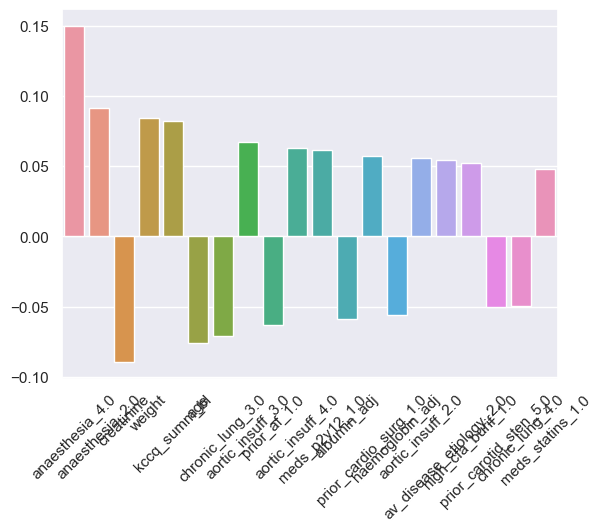

In [64]:
svm_coef = plot_cph_coef(gcv_iauc.best_estimator_.named_steps['model'].estimator_,feature_names = gcv_iauc.best_estimator_.feature_names_in_)

In [71]:
svm_coef = svm_coef.sort_values(key=abs,ascending=False)
svm_coef.to_csv("results/svm_coefs_{}.csv".format(today_stf))

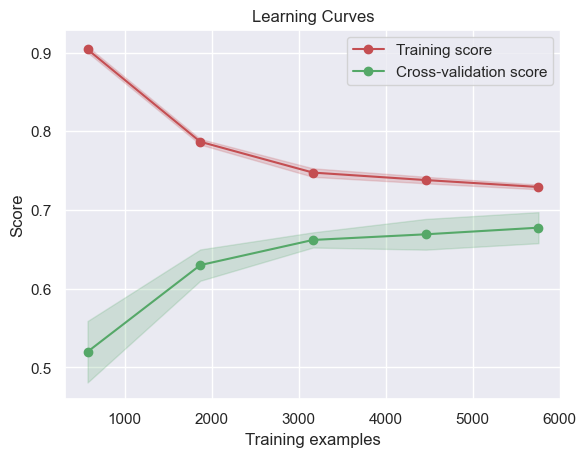

<Figure size 640x480 with 0 Axes>

In [74]:
plot_learning_curve(gcv_iauc.best_estimator_, X_train, y_train, cv=n_folds)
plt.savefig("figures/svm_learning_curve.png",bbox_inches="tight")

In [32]:
from sksurv.svm import FastKernelSurvivalSVM
cv_param_grid = {
    "model__estimator__alpha": [1e-2,0.1],
     "model__estimator__rank_ratio": [0.9,1.0],
    "model__estimator__degree": [2,3]
    
}


polysvm_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             FastKernelSurvivalSVM(random_state=random_state,kernel='poly',
                            ), tau=times[-1]))]
    )

gcv_psvm = GridSearchCV(
    polysvm_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [33]:
print(gcv_psvm.best_params_)
print(gcv_psvm.best_score_)

with open("model/psvm_{}.pkl".format(today_stf), "wb") as f:
    dump(gcv_psvm, f, protocol=5)

{'model__estimator__alpha': 0.01, 'model__estimator__degree': 2, 'model__estimator__rank_ratio': 1.0}
0.5691500725082919


In [39]:
from sksurv.svm import FastKernelSurvivalSVM
cv_param_grid = {
    "model__estimator__alpha": [5e-3,8e-3,1e-2,2e-2],
     "model__estimator__rank_ratio": [1.0],
    "model__estimator__gamma": [5e-2,8e-2,1e-1,2e-1]
    
}


rbfsvm_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             FastKernelSurvivalSVM(random_state=random_state,kernel='rbf',
                            ), tau=times[-1]))]
    )

gcv_rbfsvm = GridSearchCV(
    rbfsvm_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  self.estimator_ = self.estimator.fit(X, y, **fit_params)


In [40]:
print(gcv_rbfsvm.best_params_)
print(gcv_rbfsvm.best_score_)

with open("model/rbfsvm_{}.pkl".format(today_stf), "wb") as f:
    dump(gcv_rbfsvm, f, protocol=5)

{'model__estimator__alpha': 0.005, 'model__estimator__gamma': 0.05, 'model__estimator__rank_ratio': 1.0}
0.6439418888956465


In [43]:
rbfsvm_results = evaluate_score(gcv_rbfsvm.best_estimator_,X_test,y_test,y_train,"rbfsvm",time_max=365,time_interval=7)
results = pd.concat([results,rbfsvm_results],axis=0,ignore_index=True)
results.to_csv("results/outcome.csv")
print(results)

       model   test_ci  test_ipcw  test_auc  test_brier  n_features
0        cph  0.722376   0.728094  0.709847    0.044754          73
1        cph  0.722376   0.728094  0.709847    0.044754          73
2  lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3         dt  0.633776   0.641737  0.623690    0.045935          73
4        svm  0.720025   0.726111       NaN         NaN          75
5     rbfsvm  0.697027   0.699094       NaN         NaN          75


C:\Users\harri\AppData\Local\Temp\ipykernel_20984\535991720.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,rbfsvm_results],axis=0,ignore_index=True)


### laplacian

In [22]:
lasvm_feature_importance = pd.read_csv("results/lasvm_feature_importance_{}.csv".format(today_stf),index_col=0)

In [23]:
X_train[lasvm_feature_importance.index[:20]]

,weight,age,anaesthesia_4.0,chronic_lung_3.0,meds_p2y12_1.0,prior_carotid_sten_5.0,kccq_summ_bl,meds_beta_blocker_1.0,meds_statins_1.0,chronic_lung_2.0,aortic_insuff_4.0,av_peak_vel,prior_cardio_surg_1.0,albumin_adj,av_area_tte,prior_af_1.0,initial_bav_1.0,aortic_insuff_3.0,chronic_lung_4.0,haemoglobin_adj
ID,,,,,,,,,,,,,,,,,,,,
14830,66.0,81.0,0.0,0.0,1.0,0.0,41.953125,0.0,1.0,0.0,0.0,0.18,0.0,1.000000,0.56,0.0,0.0,1.0,0.0,1.296930
10830,68.0,80.0,1.0,0.0,1.0,1.0,21.849676,0.0,0.0,1.0,1.0,4.60,0.0,1.000000,0.80,1.0,1.0,0.0,0.0,1.682028
8105,57.0,81.0,0.0,0.0,0.0,0.0,58.467704,1.0,0.0,0.0,0.0,3.80,0.0,1.000000,0.80,1.0,1.0,0.0,0.0,1.105171
2263,88.0,92.0,1.0,0.0,1.0,1.0,18.845638,1.0,1.0,1.0,0.0,3.80,0.0,1.000000,0.30,1.0,0.0,0.0,0.0,1.083287
14207,64.0,87.0,0.0,0.0,1.0,0.0,29.933231,1.0,1.0,0.0,0.0,4.65,0.0,1.105171,0.50,0.0,0.0,1.0,0.0,2.363161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,89.0,86.0,1.0,0.0,1.0,0.0,37.117529,1.0,1.0,0.0,0.0,3.64,0.0,1.000000,0.60,1.0,0.0,1.0,0.0,1.000000
8912,81.0,83.0,1.0,0.0,0.0,1.0,12.571906,0.0,1.0,0.0,0.0,3.92,0.0,1.000000,0.90,0.0,1.0,1.0,0.0,1.000000
3920,104.0,82.0,1.0,0.0,0.0,1.0,14.498618,0.0,1.0,1.0,0.0,4.10,0.0,1.000000,0.40,0.0,0.0,1.0,0.0,1.083287


In [24]:
cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
times = np.arange(1e-5, 365, 7)

cv_param_grid = {
    "model__estimator__alpha": [8e-5,1e-4,2e-4],
     "model__estimator__rank_ratio": [1.0],
    "model__estimator__gamma": [3e-2,8e-2,1e-1,4e-1]
    
}


lasvm_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             FastKernelSurvivalSVM(random_state=random_state,kernel='laplacian',
                            ), tau=times[-1]))]
    )
for n_feature in [5]:
    gcv_lasvm = GridSearchCV(
        lasvm_pipeline,
        param_grid=cv_param_grid,
        cv=cv,
        verbose=10,
        n_jobs=2,
        return_train_score=True
    ).fit(X_train[lasvm_feature_importance.index[:n_feature]], y_train)
    print(gcv_lasvm.best_params_)
    print(gcv_lasvm.best_score_)

    with open("model/lapsvm_{}_nfeature{}.pkl".format(today_stf,n_feature), "wb") as f:
        dump(gcv_lasvm, f, protocol=5)
        
    lasvm_results = evaluate_score(gcv_lasvm.best_estimator_,X_test[lasvm_feature_importance.index[:n_feature]],y_test,y_train,"lapsvm",time_max=365,time_interval=7)
    results = pd.concat([results,lasvm_results],axis=0,ignore_index=True)
    results.to_csv("results/outcome.csv")
    print(results)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'model__estimator__alpha': 8e-05, 'model__estimator__gamma': 0.1, 'model__estimator__rank_ratio': 1.0}
0.6004473358272919
        model   test_ci  test_ipcw  test_auc  test_brier  n_features
0         cph  0.722376   0.728094  0.709847    0.044754          73
1         cph  0.722376   0.728094  0.709847    0.044754          73
2   lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3          dt  0.633776   0.641737  0.623690    0.045935          73
4         svm  0.720025   0.726111       NaN         NaN          75
5      rbfsvm  0.697027   0.699094       NaN         NaN          75
6      rbfsvm  0.697027   0.699094       NaN         NaN          75
7       lasvm  0.730869   0.735489       NaN         NaN          75
8          rf  0.716732   0.719255  0.692672    0.044753          75
9          rf  0.717167   0.722511  0.695373    0.045045          15
10        gbm  0.730200   0.735875  0.709461    0.045270 

C:\Users\harri\AppData\Local\Temp\ipykernel_2888\1779275773.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,lasvm_results],axis=0,ignore_index=True)


In [48]:
print(gcv_lasvm.best_params_)
print(gcv_lasvm.best_score_)

with open("model/lapsvm_{}.pkl".format(today_stf), "wb") as f:
    dump(gcv_lasvm, f, protocol=5)

{'model__estimator__alpha': 0.0001, 'model__estimator__gamma': 0.02, 'model__estimator__rank_ratio': 1.0}
0.6897909286785111


In [55]:
lasvm_results = evaluate_score(gcv_lasvm.best_estimator_,X_test,y_test,y_train,"lasvm",time_max=365,time_interval=7)
results = pd.concat([results,lasvm_results],axis=0,ignore_index=True)
results.to_csv("results/outcome.csv")
print(results)

       model   test_ci  test_ipcw  test_auc  test_brier  n_features
0        cph  0.722376   0.728094  0.709847    0.044754          73
1        cph  0.722376   0.728094  0.709847    0.044754          73
2  lasso_cph  0.722621   0.728389  0.701553    0.044750          73
3         dt  0.633776   0.641737  0.623690    0.045935          73
4        svm  0.720025   0.726111       NaN         NaN          75
5     rbfsvm  0.697027   0.699094       NaN         NaN          75
6     rbfsvm  0.697027   0.699094       NaN         NaN          75
7      lasvm  0.730869   0.735489       NaN         NaN          75


C:\Users\harri\AppData\Local\Temp\ipykernel_20984\1448405577.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,lasvm_results],axis=0,ignore_index=True)


In [79]:
from sklearn.inspection import permutation_importance

lasvm_feature_importance = permutation_importance(gcv_lasvm.best_estimator_, 
                                X_train, y_train, n_repeats=n_folds, random_state=random_state,n_jobs=4)

In [82]:
lasvm_feature_importance = pd.DataFrame(
    {
        k: lasvm_feature_importance[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=gcv_lasvm.best_estimator_.feature_names_in_,
).sort_values(by="importances_mean", ascending=False)

lasvm_feature_importance.to_csv("results/lasvm_feature_importance_{}.csv".format(today_stf))

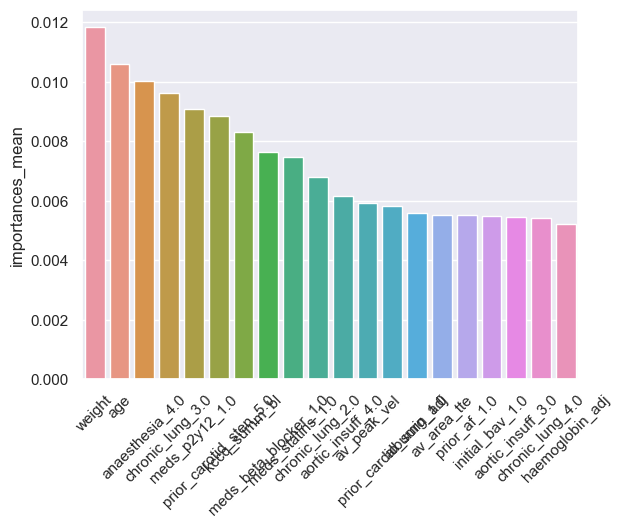

In [86]:
non_zero_rf_fi = lasvm_feature_importance.query('importances_mean > 5e-3')
ax = sns.barplot(non_zero_rf_fi, y = 'importances_mean',x=non_zero_rf_fi.index)
temp = plt.setp(ax.get_xticklabels(), rotation=45)
plt.savefig("figures/lasvm_coef.png",bbox_inches="tight")